In [2]:
'''
Introduction 

Conducting the 'wide net' analysis that is to eventually be whittled down to provide more focused results.

See 'WIP: Analysis Outline for Execution' in this project for outline guiding execution of this analysis.
'''

"\nIntroduction \n\nConducting the 'wide net' analysis that is to eventually be whittled down to provide more focused results.\n\nSee 'WIP: Analysis Outline for Execution' in this project for outline guiding execution of this analysis.\n"

In [3]:
'''
Introduction - Setup 
'''

from pandas import DataFrame, Series
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

df_climate_data_staging = pd.read_csv('Data/climate_data.csv')
df_climate_data_staging.head()

column_renaming_dict = {
    'Tn':'temp_min',
    'Tx':'temp_max',
    'Tavg':'temp_avg',
    'RH_avg':'humidity_avg',
    'RR':'rainfall',
    'ss':'duration_sunshine_hr',
    'ff_x':'wind_speed_max',
    'ddd_x':'wind_direction_at_max_speed',
    'ff_avg':'wind_speed_avg',
    'ddd_car':'wind_direction_most_frequent',
    'station_id':'station_id',
    'date':'date_recorded'
}

df_climate_data = df_climate_data_staging.rename(columns=column_renaming_dict)
df_provinces = pd.read_csv('Data/province_detail.csv')
df_stations = pd.read_csv('Data/station_detail.csv')

'''
Setup - Transformations
'''

# transforming datetime format to US
df_climate_data = df_climate_data.assign(date_recorded=df_climate_data['date_recorded'].apply(lambda x: datetime.strptime(x,'%d-%m-%Y')))

# converting index to DatetimeIndex type
df_climate_data.set_index(pd.DatetimeIndex(df_climate_data.index)) 

# producing denormlized set by merging all dataframes
df_climate_data = df_climate_data\
    .merge(df_stations,how='inner',left_on='station_id',right_on='station_id')\
		.merge(df_provinces,how='inner',left_on='province_id',right_on='province_id')

In [4]:
'''
Time Series Charts
'''

'''
TODO: 
 - [x] Aggregate averages via *weighted* average
 - [ ] Identify outliers in the temperature and how we should treat such (removal from data set?
 - [x] Properly resample temperature data by applying separate aggregation for each aggregation type (i.e. min for temp_min and max for temp_max, rather than 'max' for both)
 - [ ] Clean up the final chart as needed
	- Is it possible to add a trend line here?
'''

'''
Time Series Charts -- Initial Group and Aggregation

Group and aggregate each of the individual station data by the recorded date.
'''

temp_min_named_agg = pd.NamedAgg('temp_min','min')
temp_max_named_agg = pd.NamedAgg('temp_max','max')
temp_avg_named_agg = pd.NamedAgg('temp_avg','mean')
temp_avg_named_count = pd.NamedAgg('temp_avg','count')

df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        temp_max=temp_max_named_agg, 
				temp_min=temp_min_named_agg, 
				temp_avg=temp_avg_named_agg,
        temp_count=temp_avg_named_count
			)


'''
Time Series Charts -- Time Resampling

Further group and aggregate over each month of recordings. 

The average temperature calculation performs as follows:

(avg1*count1 + avg2*count2 + ... + avgN*countN)/(count1 + count2 + ... + countN)

Some additional commentary:

It seems that the resample(),agg(), and apply() functions all accept 
lamdba functions where the 'data' argument that is passed to each is 
dependent on the object passed - i.e. if we're calling dataframe.apply(lambda x: x)
then 'x' is a DataFrame object (i.e. what the apply() is acting on in this context)
, whereas if we call series.apply(lambda x: x) then x is that Series object the apply() 
function is acting on.
'''
df_climate_data_tmp2 = DataFrame(
    {
        'temp_max':df_climate_data_tmp['temp_max'].resample('1M').max(),
     		'temp_min':df_climate_data_tmp['temp_min'].resample('1M').min(),
				'temp_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.temp_count * x.temp_avg)/sum(x.temp_count))
		}
  )


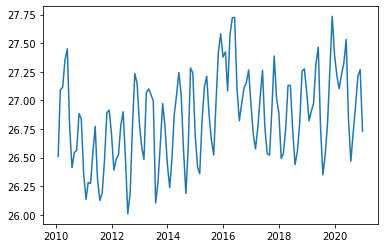

In [5]:
# plotting average temperature data resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['temp_avg'])

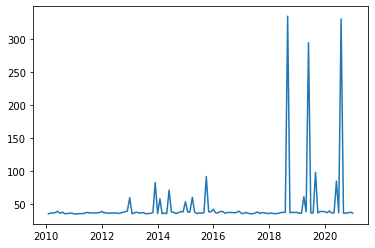

In [6]:
# plotting maximum temperature data resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['temp_max'])

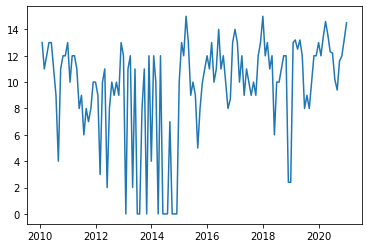

In [7]:
# plotting minimum temperature data resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['temp_min'])

In [8]:
'''
Time Series Charts - Rainfall
'''

rainfall_min_named_agg = pd.NamedAgg('rainfall','min')
rainfall_max_named_agg = pd.NamedAgg('rainfall','max')
rainfall_avg_named_agg = pd.NamedAgg('rainfall','mean')
rainfall_avg_named_count = pd.NamedAgg('rainfall','count')

df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        rainfall_max=rainfall_max_named_agg, 
				rainfall_min=rainfall_min_named_agg, 
				rainfall_avg=rainfall_avg_named_agg,
        rainfall_count=rainfall_avg_named_count
			)

df_climate_data_tmp2 = DataFrame(
    {
        'rainfall_max':df_climate_data_tmp['rainfall_max'].resample('1M').max(),
     		'rainfall_min':df_climate_data_tmp['rainfall_min'].resample('1M').min(),
				'rainfall_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.rainfall_count * x.rainfall_avg)/sum(x.rainfall_count))
		}
  )

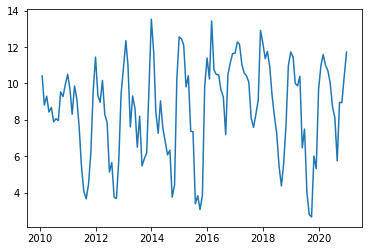

In [9]:
# plotting average rainfall resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['rainfall_avg'])

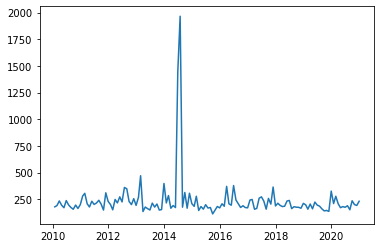

In [10]:
# plotting maximum rainfall resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['rainfall_max'])

In [11]:
'''
Time Series Charts - Humidity
'''

humidity_min_named_agg = pd.NamedAgg('humidity_avg','min')
humidity_max_named_agg = pd.NamedAgg('humidity_avg','max')
humidity_avg_named_agg = pd.NamedAgg('humidity_avg','mean')
humidity_avg_named_count = pd.NamedAgg('humidity_avg','count')

df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        humidity_max=humidity_max_named_agg, 
				humidity_min=humidity_min_named_agg, 
				humidity_avg=humidity_avg_named_agg,
        humidity_count=humidity_avg_named_count
			)

df_climate_data_tmp2 = DataFrame(
    {
        'humidity_max':df_climate_data_tmp['humidity_max'].resample('1M').max(),
     		'humidity_min':df_climate_data_tmp['humidity_min'].resample('1M').min(),
				'humidity_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.humidity_count * x.humidity_avg)/sum(x.humidity_count))
		}
  )

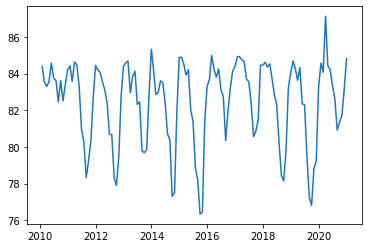

In [12]:
# plotting average humidity data resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['humidity_avg'])

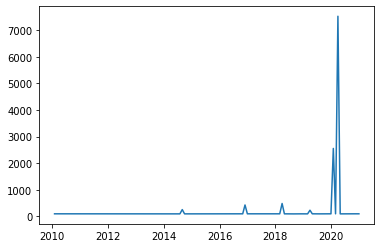

In [13]:
# plotting maximum humidity data resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['humidity_max'])

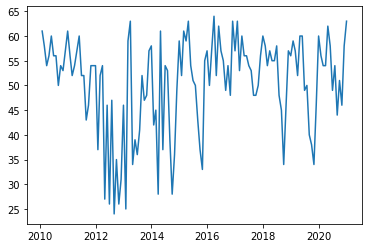

In [14]:
# plotting minimum humidity data resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['humidity_min'])

In [15]:
'''
Time Series Charts - Duration of Sunshine
'''

sunshine_min_named_agg = pd.NamedAgg('duration_sunshine_hr','min')
sunshine_max_named_agg = pd.NamedAgg('duration_sunshine_hr','max')
sunshine_avg_named_agg = pd.NamedAgg('duration_sunshine_hr','mean')
sunshine_avg_named_count = pd.NamedAgg('duration_sunshine_hr','count')

df_climate_data_tmp = df_climate_data.groupby('date_recorded')\
    .agg(
        sunshine_max=sunshine_max_named_agg, 
				sunshine_min=sunshine_min_named_agg, 
				sunshine_avg=sunshine_avg_named_agg,
        sunshine_count=sunshine_avg_named_count
			)

df_climate_data_tmp2 = DataFrame(
    {
        'sunshine_max':df_climate_data_tmp['sunshine_max'].resample('1M').max(),
     		'sunshine_min':df_climate_data_tmp['sunshine_min'].resample('1M').min(),
				'sunshine_avg':df_climate_data_tmp.resample('1M').agg(func=lambda x: sum(x.sunshine_count * x.sunshine_avg)/sum(x.sunshine_count))
		}
  )

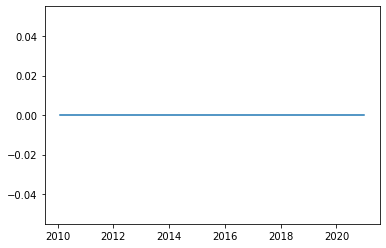

In [16]:
# plotting minimum sunshine duration resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['sunshine_min'])

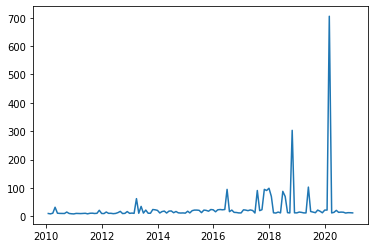

In [17]:
# plotting maximum sunshine duration resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['sunshine_max'])

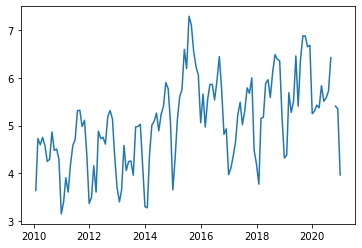

In [18]:
# plotting average sunshine duration resulting from previous transformations
fig, ax = plt.subplots()
ax.plot(df_climate_data_tmp2.index,df_climate_data_tmp2['sunshine_avg'])

In [19]:
'''
Summary Statistics

- [ ] Determine what the summary statistics analysis contents should contain
'''

'\nSummary Statistics\n\n- [ ] Determine what the summary statistics analysis contents should contain\n'

In [20]:
'''
Summary Statistics - By Province
'''


df_climate_data[
    ['province_id',
     'province_name',
			'humidity_avg',
			'rainfall',	
			'temp_max',
			'temp_avg'
			]].groupby(['province_id','province_name'],as_index=False)\
    .agg(['mean','max','std','min'])

humidity_avg                           \
                                             mean     max        std   min   
province_id province_name                                                    
1           Nanggroe Aceh Darussalam    84.087019   100.0   6.588316  49.0   
2           Sumatera Utara              83.887111   100.0   5.577903  34.0   
3           Sumatera Barat              83.720705  2555.0  23.904442  24.0   
4           Riau                        82.417038    98.0   5.393189  46.0   
5           Jambi                       83.885162    98.0   4.811024  42.0   
6           Sumatera Selatan            83.471118    98.0   5.666749  58.0   
7           Bengkulu                    85.008233   259.0   4.731756  62.0   
8           Lampung                     81.710272    98.0   6.093523  35.0   
9           Kep. Bangka Belitung        85.953549   235.0   6.243904  58.0   
10          Kep. Riau                   84.392484   100.0   5.339398  52.0   
11          DKI Jakarta                 76.481059   100.0   6.612952  47.0   
12          Jawa Barat                  80.719843   100.0   8.440516  35.0   
13          Jawa Tengah                 77.768719    97.0   7.590966  39.0   
14          DI Yogyakarta               83.441821    98.0   5.501376  56.0   
15          Jawa Timur                  79.311232    99.0   7.867313  34.0   
16          Banten                      80.767948  7520.0  54.393304  34.0   
17          Bali                        80.867473    99.0   5.565918  25.0   
18          Nusa Tenggara Barat         80.812328    98.0   6.751992  50.0   
19          Nusa Tenggara Timur         79.050434   100.0   8.093108  33.0   
20          Kalimantan Barat            84.735334   100.0   4.902913  43.0   
21          Kalimantan Tengah           85.291229   100.0   4.859521  63.0   
22          Kalimantan Selatan          83.813761   100.0   6.125518  43.0   
23          Kalimantan Timur            84.777974   100.0   5.209748  52.0   
24          Sulawesi Utara              82.279450  5045.0  40.190243  37.0   
25          Sulawesi Tengah             80.237767    98.0   6.276278  47.0   
26          Sulawesi Selatan            81.488845   100.0   7.752371  28.0   
27          Sulawesi Tenggara           81.514608   100.0   6.807965  51.0   
28          Gorontalo                   82.039752   100.0   5.929539  48.0   
29          Sulawesi Barat              79.559663    97.0   5.020832  53.0   
30          Maluku                      84.921969   100.0   5.296844  46.0   
31          Maluku Utara                84.379124    99.0   4.911100  53.0   
32          Papua                       83.858985   100.0   5.647330  37.0   
33          Papua Barat                 84.536257   100.0   5.205052  54.0   
34          Kalimantan Utara            84.072695    98.0   4.611518  37.0   

                                       rainfall                          \
                                           mean     max        std  min   
province_id province_name                                                 
1           Nanggroe Aceh Darussalam   8.576935   240.0  17.818094  0.0   
2           Sumatera Utara             9.310504   269.0  17.756096  0.0   
3           Sumatera Barat            15.065508   470.0  25.745169  0.0   
4           Riau                       8.583530   201.5  16.977942  0.0   
5           Jambi                      7.618180   159.8  14.520703  0.0   
6           Sumatera Selatan           9.418426   214.1  17.457555  0.0   
7           Bengkulu                  10.682361   257.5  19.575940  0.0   
8           Lampung                    8.812861   204.9  16.288308 -1.0   
9           Kep. Bangka Belitung       8.889835   232.3  16.791733  0.0   
10          Kep. Riau                  7.873538   279.5  16.867726  0.0   
11          DKI Jakarta                7.735936   305.0  18.216419  0.0   
12          Jawa Barat                 9.680245   212.3  17.808449  0.0   
13          Jawa Tengah  

In [21]:
# execute describe() as alternative to previous code execution 
'''
TODO: Summary Analysis - 2023_07_08_1

Analyzing the output below in Excel to 
  - [ ] If there isn't a visulization opportunity obvious, identify some questions to ask of the data
  	- Limit analysis to 1 or 2 metrics to enable more focused effort 
	- [ ] Identify 2 - 3 visualization opportunties
  - [ ] Identify and describe general approaches for using summary statistics as a 'map' for deeper analysis in notebook's conclusion (or elsewhere)
'''
df = df_climate_data[
    ['province_id',
     'province_name',
			# 'humidity_avg',
			# 'rainfall',	
			# 'temp_max',
			# 'temp_min',
			'temp_avg'
			]].groupby(['province_id','province_name'])\
    .describe()

df.to_clipboard()

``` 
WIP: Summary Analysis - 2023_07_08_1
```

Observations of the data:
 - The temp_avg column is the average temperature for the day on record
 - ...

In [22]:
'''
Some exceptional maximums:

 - 'DKI Jakarta' province with a maximum of 334 C (633 F)
 - 'Jawa Tengah' province with maximum of 330 C (626 F)
 - 'Papua' province with a maximum of 294 C (561 F)

It seems to me that 60 C is a cutoff point for sensible maximum temperatures. Here's a list of all the individual max daily temperature records greater than or equal to 60 C (140 F):

List....

We see here that the maximum temperatures are quite different from the average recorded daily temperature in a few of these instances, which provides even more of a suggestion (if any was needed), that these temperatures are anomalies and may be filtered out.
'''

'''
Comparatively, there are a few minimum temperature instances that seem very different from the average temperature that day, again strongly suggesting that the temperatures are in error.

List...
'''

# df.temp_max
# df.temp_min.to_clipboard()
df_climate_data[df_climate_data.temp_max> 60 ][['station_name', 'date_recorded','temp_max','temp_avg']]
# df_climate_data[df_climate_data.temp_max == 0].shape[0]

# df_climate_data.max()

,station_name,date_recorded,temp_max,temp_avg
53437,Stasiun Geofisika Gunungsitoli,2015-03-04,60.6,NaN
74916,Stasiun Meteorologi Dabo,2014-05-01,71.6,27.9
127879,Stasiun Geofisika Tanjung Pandan,2019-03-05,61.6,27.5
136653,Stasiun Klimatologi Bengkulu,2012-12-16,60.1,26.5
276025,Halim Perdana Kusuma Jakarta,2018-08-01,321.8,27.8
276042,Halim Perdana Kusuma Jakarta,2018-08-18,334.0,27.0
300708,Stasiun Meteorologi Tunggul Wulung,2020-07-10,330.0,26.6
345269,Stasiun Geofisika Malang,2013-11-23,83.0,25.7
502880,Stasiun Meteorologi Oesman Sadik,2020-05-04,85.0,26.7
534741,Stasiun Meteorologi Nabire,2020-05-07,83.0,28.6


[]

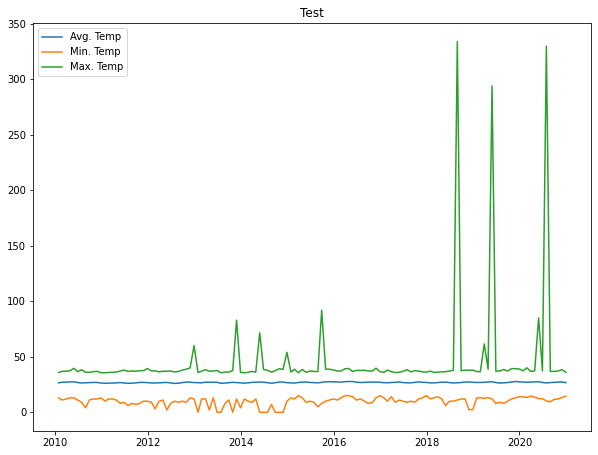

In [23]:
'''
Filtering out the extreme temperatures from the plot and plotting the sampled minimum, maximum, and average temperatures all in one plot:

(Running same logic as previous)

The signifiant maximums are still a little suspicious and it may be worthwhile to investigate their validity a little more.

What's worth calling out here is there is not an obvious upward increase in temperature that might expect to see as a result of global warming, however global warming overall is slight (i.e. 1 degree C over an entire century) in the context of the temperature range, and shouldn't be apparent here anyways.
....
'''
df_climate_data_filtered = df_climate_data[(df_climate_data.temp_min > 0) & (df_climate_data.temp_max < 60)]
df_climate_data_filtered = df_climate_data[(df_climate_data.humidity_avg <= 100)]


temp_min_named_agg = pd.NamedAgg('temp_min','min')
temp_max_named_agg = pd.NamedAgg('temp_max','max')
temp_avg_named_agg = pd.NamedAgg('temp_avg','mean')
temp_avg_named_count = pd.NamedAgg('temp_avg','count')

df_climate_data_filtered_tmp = df_climate_data_filtered.groupby('date_recorded')\
    .agg(
        temp_max=temp_max_named_agg, 
				temp_min=temp_min_named_agg, 
				temp_avg=temp_avg_named_agg,
        temp_count=temp_avg_named_count
			)

df_climate_data_filtered_tmp2 = DataFrame(
    {
        'temp_max':df_climate_data_filtered_tmp['temp_max'].resample('1M').max(),
     		'temp_min':df_climate_data_filtered_tmp['temp_min'].resample('1M').min(),
				'temp_avg':df_climate_data_filtered_tmp.resample('1M').agg(func=lambda x: sum(x.temp_count * x.temp_avg)/sum(x.temp_count))
		}
  )


fig, ax = plt.subplots(figsize=(10,7.5))
ax.set_title('Test')
ax.plot(df_climate_data_filtered_tmp2.index,df_climate_data_filtered_tmp2['temp_avg'], label='Avg. Temp')
ax.plot(df_climate_data_filtered_tmp2.index,df_climate_data_filtered_tmp2['temp_min'], label='Min. Temp')
ax.plot(df_climate_data_filtered_tmp2.index,df_climate_data_filtered_tmp2['temp_max'], label='Max. Temp')
ax.legend()
ax.plot()


In [24]:
'''
WIP: Analyzing average temperature summary statistics for additional visualization opportunities
'''

df = df_climate_data_filtered[
    ['province_id',
     'province_name',
			'humidity_avg',
			'rainfall',	
			'temp_max',
			'temp_min',
			'temp_avg'
			]].groupby(['province_id','province_name'])\
    .describe()

df['temp_avg'].to_clipboard()
# df['humidity_avg'].to_clipboard()

In [25]:
df_climate_data_filtered[[
    #  'province_name',
    #  'station_name',
    #  'region_name'
			'humidity_avg',
			'rainfall',	
			'temp_max',
			'temp_min',
			'temp_avg'
			]].describe()

,humidity_avg,rainfall,temp_max,temp_min,temp_avg
count,541076.000000,432641.000000,518151.000000,522095.000000,540264.000000
mean,82.459874,8.574314,31.574314,23.363137,26.858184
std,6.774456,17.845941,2.278376,2.251977,1.938110
min,24.000000,-1.000000,0.000000,0.000000,12.700000
25%,79.000000,0.000000,30.600000,23.000000,26.200000
50%,83.000000,1.000000,31.800000,24.000000,27.200000
75%,87.000000,9.000000,33.000000,25.000000,28.000000
max,100.000000,1965.500000,334.000000,246.000000,141.600000


In [26]:
'''
Correlation
'''

'\nCorrelation\n'

In [27]:
'''
Conclusion
'''

'\nConclusion\n'